# PHY480/905 Semester Final Project 

#### PHY 480/905 Semester Project
### &#9989; Aaron Philip
#### &#9989; Last Updated: 28 April, 2023


# **Applying Multigrid Methods and ML to the Heat Equation**

## **Introduction**


### **Background and Motivation**
In the computational treatment of partial differential equations (PDEs), a common approach is to discretize the PDE into a system of ordinary differential equations (ODEs) to solve concurrently to evolve the sytem forward. However, such systems tend to be stiff for discretized parabolic PDEs. One option is to use an **explicit** integration scheme of the form 
\begin{equation}
    u_{k+1} = u_{k} + \Delta t f(t,u_{k}) 
\end{equation}
such that $u$ is the solution to the ODE $ f(t,u) = \dot u$.
However, such integration schemes have severe constraints on step size ($\Delta t$), making them ill-suited for simulations over larger time-scales. **Implicit** schemes allow for larger steps and have the form 
\begin{equation}
    u_{k+1} = u_{k} + \Delta t f(t,u_{k+1}) 
\end{equation}. 
Because $u_{k+1}$ exists on both sides, solving a system of coupled equations becomes necessary, increasing cost significantly. To ameliorate this cost, iterative schemes have been employed to great effect. Some examples include Jacobi iteration, Gauss Seidel iteration, and this paper's topic of study: multigrid methods. 

To demonstrate, observe the following. Using the simplest implicit scheme, backward Euler, a time dependent problem can be posed in the form
\begin{equation}
    u_{k+1} = u_k + \Delta t (L u_{k+1} + f) 
\end{equation}
such that $Lu + f = \dot u$. Rearranging gives
\begin{equation}
    (I - \Delta tL)u_{k+1} = u_{k} + \Delta t f
\end{equation}

When solving a PDE in 2D or higher, the matrix $I - \Delta tL$ quickly becomes far too large to invert due to its $O(n^4)$ scaling. The same holds for attempting to solve the solution exactly. Hence, iterative methods are used to converge to $u_{k+1}$ from $u_k$. Jacobi and Gauss Seidel iterations are local correction schemes that specialize in removing high frequency error but converge smooth errors very slowly. Multigrid methods correct this issue by projecting the solution onto grids with various resolutions and removing different frequencies of error then projecting corrections to high resolution grids. The Full Multigrid algorithm has $O(n)$ complexity, but even iterating the V-cycle algorithm with $O(nlogn)$ scaling can be dramatically effective.

In this study, the 2D heat equation 
\begin{equation}
    \nabla ^2 u = u_{t}
\end{equation}
was treated by various methods to characterize the efficacy and scaling of 

-  Using an explicit Runge-Kutta scheme alongside finite differences.
-  Training an ML model to capture time dynamics for a specific solution.
-  Using multigrid v-cycle with an implicit scheme to obtain a time trajectory. 

###**Research Questions:** 

The guiding question can be summarized as follows: 

####**Can we take advantage of multigrid methods and machine learning to avoid tedious computation from integration?**

I sought to answer this question with the following "sub-questions":

1.  Can we implement the recursive V-cycle multigrid algorithm in a general way so that it can solve static and time-dependent problems alike?

1.  Can we train an ML model to accurately capture time-dynamics of a specific solution?

1. How do these techniques compare to other solution methods such as Jacobi and Explicit Runge-Kutta?




## **Methodology**


The imports and installations below will enable the reproduction of all results/figures below.

In [74]:
!git clone https://github.com/aaron-philip/Laplacian-NIF.git
!pip install scienceplots
!pip install git+https://github.com/pswpswpsw/nif.git

Cloning into 'Laplacian-NIF'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 45 (delta 8), reused 11 (delta 1), pack-reused 0
Unpacking objects: 100% (45/45), 705.19 KiB | 4.70 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pswpswpsw/nif.git to /tmp/pip-req-build-2qskb3y0
  Running command git clone --filter=blob:none --quiet https://github.com/pswpswpsw/nif.git /tmp/pip-req-build-2qskb3y0
  Resolved https://github.com/pswpswpsw/nif.git to commit 0286df9076d87ffce0d482ecf305180bcb854c80
  Preparing metadata (setup.py) ... done


In [63]:
import tensorflow as tf
import nif
import numpy as np
from scipy.integrate import solve_ivp
import time
import logging
import contextlib
from matplotlib import pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])
from mpl_toolkits import mplot3d
from nif.optimizers import centralized_gradients_for_optimizer
from nif.layers import JacobianLayer, HessianLayer
import math
from sklearn.utils import shuffle
import h5py
import os
import random
from contextlib import nullcontext

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from numpy import empty, zeros, max, copy
from pylab import imshow, gray, show

### **Part I: Multigrid V-Cycle**

This is the code written to solve matrix problems of the form Ax=b in which x is specifically a flattened field with Dirichlet Boundary Conditions. 

In [82]:
class MultiGridSolver2D:
    
    """
    General 2D Geometric Multigrid solver for Dirichlet BC posed in form Ax=b. 
    Capabilities: Any static problem, assuming the above conditions are satisfied. 
                  Time-dependent is enabled as well. Boundary conditions must be dealt with beforehand.              
    Restrictions: The mesh must be square.
                  The number of fine-mesh points must be odd. 
                  Higher accuracy/faster convergence follows from using a dimension 2^n+1
    
    """
    
    def __init__(self, construct_A, b, x0, dim, max_grids=10, iter_max=25):
        """
        Constructor
        Inputs: 
            construct_A: A function to discretize the linear operator over any desired mesh WITHOUT BC.
            It must take in a single mesh direction
            b: Vector of field WITHOUT BC for Ax=b but accounted for (the way RDAY 18 PC does).
            x0: Initial solution guess WITH BC. The BC are fixed
            dim: The number of points in a single dimension (including the BC)
            max_grids: The number of grids utilized for coursening (including the fine grid)
            iter_max: Number of Jacobi relaxations on each grid
        """
        self.construct_A = construct_A 
        self.A = self.construct_A(dim-2) # A is only needed for interior points of mesh
        self.b = b.flatten()
        self.max_grids = max_grids
        self.dim = dim # most effective when it is 1 + 2^n for some positive integer n
        self.iter_max = iter_max
        self.x0 = x0.reshape(dim,dim)
        self.current_grid = 1
     
    def next_dim(self, current_dim):
        """
        shortcut to determine next grid length
        """
        return int((current_dim-1)/2)
    
    def construct_A_wrapper(self, n):
        """
        Wrapper func for user specified function that constructs the linear operator on a mesh
        """
        return self.construct_A(n)
    
    def solve(self, cycle_count=1):
        """
        Wrapper for solve function
        """
        x_solved = self.x0.copy()
        
        for i in range(cycle_count):
            
            # we can't change the boundary but we can pose the problem as if error is zero on boundaries
            x_solved[1:-1,1:-1] = self.v_cycle(self.A, self.b, x_solved[1:-1,1:-1].flatten(), self.dim-2).copy()
        
        return x_solved
    
    def v_cycle(self, A_h, b_h, x0_h, dim):
        
        """
        This function is a recursive V-cycle multigrid solver. 
        Notes: The '_h' at the end of the variables denotes resolution; 2h is 2x coarser than h (in each dim).
        'dim' means the length of a side WITH boundary conditions
        """
        
        # base case: Either at the coursest grid specified or we are at the coursest grid possible
        if(self.current_grid==self.max_grids or dim%2==0 or dim==1):
            x_base = x0_h.reshape(dim, dim)
            
            # Solve on the coursest grid via relaxation.
            x_base = self.weighted_jacobi(inA=A_h, inb=b_h, 
                                                         x0=x_base.flatten(),
                                                         iter_max=self.iter_max).reshape(dim,dim)
            return x_base
        
        else:
            self.current_grid += 1
            
            # Relax on current grid
            x_soln = x0_h.reshape(dim, dim).copy()
            x_soln = self.weighted_jacobi(inA=A_h, inb=b_h, 
                                                         x0=x_soln.flatten(),
                                                         iter_max=self.iter_max).reshape(dim,dim)
            # Compute residual after relaxation
            r_h = b_h - np.matmul(A_h, x_soln.flatten())
            
            next_dim = self.next_dim(dim)
            
            # Solve for the error recursively 
            A_2h, r_2h = self.coursen(A_h, r_h, dim)
            e_2h = 0*r_2h.copy() # Initial guess just needs to be the zero vector
            e_2h = self.v_cycle(A_2h, r_2h, e_2h, dim=next_dim)

            # Correct the current grid with interpolated error from the previous grid
            x_soln = self.interpolate(e_2h.reshape(next_dim,next_dim)) + x_soln
            
            # Post-smoothing: relaxing again can be very effective if iter_max is very low (eg. 1-3)
            x_soln = self.weighted_jacobi(inA=A_h, inb=b_h,
                                          x0=x_soln.flatten(),
                                          iter_max=self.iter_max).reshape(dim,dim)
            return x_soln
    
    def coursen(self, A_h, r_h, dim):
        """
        Input: The linear operator and the residual on the finer grid.
        Returns: The coursened version of the inputs for the next courser grid.
        """
        r_h = r_h.reshape(dim,dim).copy()
        r_2h = np.zeros((self.next_dim(dim), self.next_dim(dim)))
        A_2h = self.construct_A_wrapper(self.next_dim(dim)) # rediscretize operator on courser grid
        
        # Full weighting to project residual onto courser grid. 
        # Injection is a less effective version (although cheaper)
        for i in range(r_2h.shape[0]):
            for j in range(r_2h.shape[0]):
                
                # Calculate the indices of the corresponding fine grid points
                fi = int(2*i+1)
                fj = int(2*j+1)
                indices = [(fi-1, fj-1), (fi-1, fj), (fi-1, fj+1),
                           (fi, fj-1),   (fi, fj),   (fi, fj+1),
                           (fi+1, fj-1), (fi+1, fj), (fi+1, fj+1)]

                # Stencil for weighting
                weights = np.array([1/16, 1/8, 1/16,
                                    1/8, 1/4, 1/8,
                                    1/16, 1/8, 1/16])
                
                r_h_values = np.zeros(9)
                for k, (fx, fy) in enumerate(indices):
                    r_h_values[k] = r_h[fx,fy]

                # Calculate the coarsened value as a weighted sum of the fine grid values
                r_2h[i,j] = np.dot(weights, r_h_values.flatten())
        return A_2h, 4*r_2h.flatten()
    
    def interpolate(self, e_2h):
        """
        Input: The course error
        Returns: The interpolated error onto a mesh 2x finer. 
        Assuming error is 0 on boundaries is why we can use the interpolation matrix
        """
        dim = e_2h.shape[0]
        I_2h_to_h = self.interpolation_matrix(dim) # interpolation matrix
        e_h = np.zeros((I_2h_to_h.shape[0],I_2h_to_h.shape[0]))    
        
        # temporary h x 2h matrix to hold interpolated rows before cols have been treated
        temp_h = np.zeros((dim,e_h.shape[0])) 
        
        # interpolation in rows first
        for i in range(0,e_h.shape[0]-1,2):
            interp_row = np.matmul(I_2h_to_h, e_2h[int(i/2)])
            temp_h[int(i/2)] = interp_row.copy()
        
        # interpolate cols of the current fat-short matrix to obtain fully interpolated field 
        for i in range(0,e_h.shape[0],1):
            interp_col = np.matmul(I_2h_to_h, temp_h[:,i])
            e_h[:,i] = interp_col.copy()
            
        return e_h
            
    def interpolation_matrix(self, n):
        """
        When used on a 1D vector, it performs linear interpolation to map n-vector to (n*2+1)-vector
        n must be odd. Bilinear (2D) interpolation comes from sweeping in each direction sequentially.
        """
        I = np.zeros((2*n+1, n))
        for i in range(n):
            I[2*i:2*i+3,i] = [0.5,1,0.5]
        return I 
    
    def weighted_jacobi(self, inA, inb, x0=None, iter_max=10):
        """
        Weighted jacobi exhibits faster convergence when the weight is chosen well.
        """
        inb = inb.flatten()
        n = inA.shape[0]
        if x0 is None:
            x0 = np.zeros(n)
        else: 
            x0 = x0.flatten()

        w = 4.0/5 # weight factor
        x = x0.copy()
        x_new = np.zeros_like(x)
        for it in range(iter_max):
            for i in range(n):
                x_new[i] = (1 - w) * x[i] + w / inA[i, i] * (inb[i] - inA[i, :].dot(x) + inA[i, i] * x[i])
            x = x_new.copy()
        return x

**Application: The Laplace Equation**

We solved this equation in PC-18 using the jacobi relaxation method. This is the same problem but now solved using Multigrid.

In [83]:
def finite_difference_matrix_2D(n):
    """
    The tridiagonal matrix of 2D 2nd degree finite difference. Used to construct operator
    """
    L = np.zeros([n,n])
    for i in range(n):
        L[i,i] = -4
        if(i<n-1):
            L[i,i+1] = 1
            L[i+1,i] = 1
    return L

def construct_A(n):
    """
    The Laplace operator. It has a tri-block-diagonal structure with FD matrix on diagonal
    and identity on off diagonal.
    """
    A = np.zeros([n**2,n**2])
    L = finite_difference_matrix_2D(n)
    I = np.identity(n)
    for i in range(n):
        A[i*n:(i+1)*n, i*n:(i+1)*n] = L
        if(i<n-1):
            A[i*n:(i+1)*n, (i+1)*n:(i+2)*n] = I
            A[(i+1)*n:(i+2)*n, i*n:(i+1)*n] = I
    return A

# will plot a slice of the mesh of the temperature 
def plotDomain(mesh):
    pos = plt.imshow(mesh,
              extent =[-1, 1, -1, 1],
              interpolation='nearest', cmap='rainbow', origin ='lower')
    plt.xlabel('Y', fontweight="bold",fontsize=14)
    plt.ylabel('X', fontweight="bold",fontsize=14)
    plt.title("Temperature Field", fontweight="bold", fontsize=20)
    plt.grid(color = 'white',which='major', alpha=0.5)
    plt.grid(color = 'white',which='minor', alpha=0.2)
    plt.colorbar(pos)

Initial Residual Norm 7.937253933193772
After one V-cycle (3 jacobi per level):  0.45291973864478496


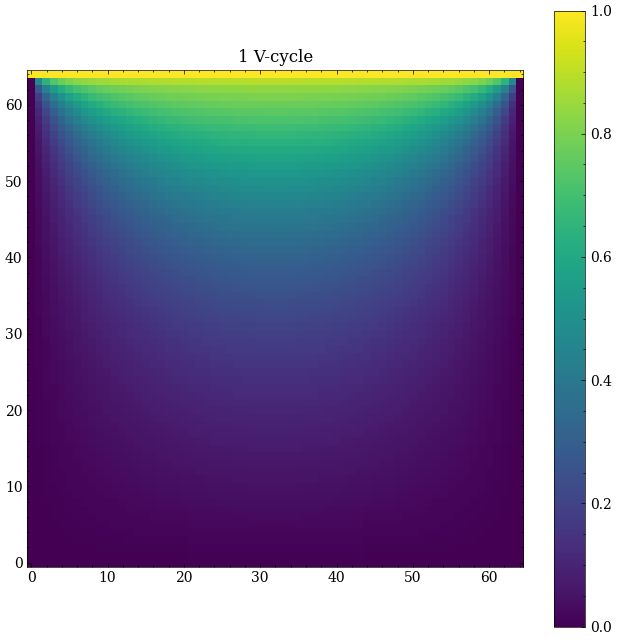

Initial Residual Norm 7.937253933193772
After one V-cycle (3 jacobi per level):  0.00898636288690639


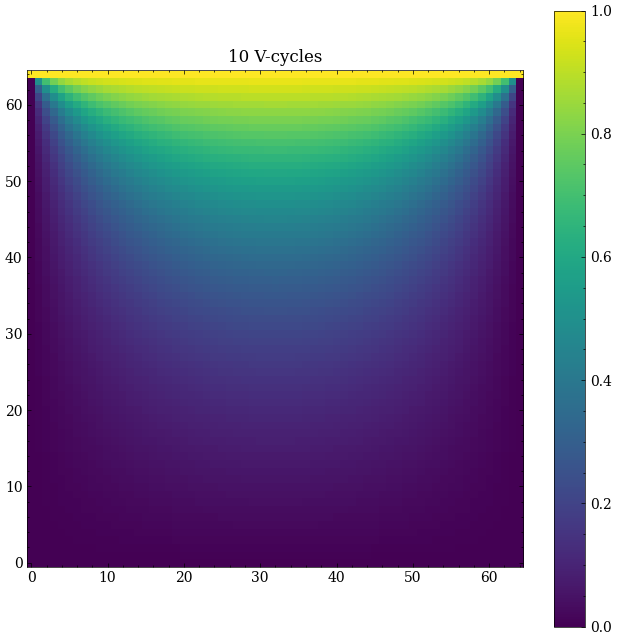

In [84]:
# Dimension, potential, target convergence 
M = 65         # Side length/n_points, must be odd!!!
V = 1.0         # Potential source strength

# x0 = grid, set boundary condition for potential source
x0 = np.zeros([M,M],float)
x0[-1,:] = V
b = np.zeros_like(x0[1:-1, 1:-1])

# move Dirichlet boundary conditions to b to avoid interfering with it
#b[M-3] = b[M-3] - x0[M-1,1:-1]

b[-1] = b[-1] - x0[-1,1:-1]
b[0] = b[0] - x0[0,1:-1]
b[:,-1] = b[:,-1] - x0[1:-1,-1]
b[:,0] = b[:,0] - x0[1:-1,0]
A = construct_A(M-2)
iter_max = 3

"""Demonstration for single V-cycle"""
MGS = MultiGridSolver2D(construct_A, b, x0, dim=M, iter_max=iter_max)
x = MGS.solve()
print("Initial Residual Norm", np.linalg.norm(b.flatten() - A@x0[1:-1,1:-1].flatten()))
print("After one V-cycle (%i jacobi per level): "%iter_max, np.linalg.norm(b.flatten()-A@x[1:-1,1:-1].flatten()))
fig = plt.figure(figsize=(8,8))
s = plt.imshow(x, origin='lower')
plt.title("1 V-cycle")
plt.colorbar(s)
plt.show()


"""Multiple V-cycles"""
MGS = MultiGridSolver2D(construct_A, b, x0, dim=M, iter_max=iter_max)
x = MGS.solve(10)
print("Initial Residual Norm", np.linalg.norm(b.flatten() - A@x0[1:-1,1:-1].flatten()))
print("After one V-cycle (%i jacobi per level): "%iter_max, np.linalg.norm(b.flatten()-A@x[1:-1,1:-1].flatten()))
fig = plt.figure(figsize=(8,8))
s = plt.imshow(x, origin='lower')
plt.title("10 V-cycles")
plt.colorbar(s)
plt.show()

**Comparison of Jacobi and Multigrid**

To demonstrate the efficiency of the V-cycle algorithm, the following example shows the computatioanl scaling of Jacobi and Multgrid on a 65x65 grid. The residual norm is a measure of how much the solution obtained fails to satisfy the matrix equation. 

In [67]:
# Modified from RDAY-PC 18
def jacobi_laplace(tol):
    # Dimension, potential, target convergence 
    M = 65          # Side length/n_points
    V = 1.0         # Potential source strength

    # phi = grid, set boundary condition for potential source
    phi = zeros([M+1,M+1],float)
    phi[M,:] = V
    phinew = copy(phi)

    st = time.time()
    # iteration loop 
    delta = 100
    while delta > tol:
    
        # update each value of the grid based on adjacent values. Don't touch boundaries
        for i in range(1,M):
            for j in range(1,M):
                phinew[i,j] = (phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1])/4

        # compute residual between iterations
        delta = np.linalg.norm((phi-phinew))

        # set new iterations 
        phi, phinew = phinew, phi
    end = time.time()
    return phinew, (end-st)

def multigrid_laplace(it):
    # Dimension, potential, target convergence 
    M = 65         # Side length/n_points, must be odd!!!
    V = 1.0         # Potential source strength

    # x0 = grid, set boundary condition for potential source
    x0 = np.zeros([M,M],float)
    x0[-1,:] = V
    b = np.zeros_like(x0[1:-1, 1:-1])
    iter_max = 10
    # move Dirichlet boundary conditions to b to avoid interfering with it
    #b[M-3] = b[M-3] - x0[M-1,1:-1]

    b[-1] = b[-1] - x0[-1,1:-1]
    b[0] = b[0] - x0[0,1:-1]
    b[:,-1] = b[:,-1] - x0[1:-1,-1]
    b[:,0] = b[:,0] - x0[1:-1,0]
    A = construct_A(M-2)
    #iter_max = 3

    """Iterated V-cycles"""
    st = time.time()
    MGS = MultiGridSolver2D(construct_A, b, x0, dim=M, iter_max=it)
    x = MGS.solve(10)
    end = time.time()
    # return largest error, time taken 
    return np.linalg.norm(b.flatten()-A@x[1:-1,1:-1].flatten()), (end-st)

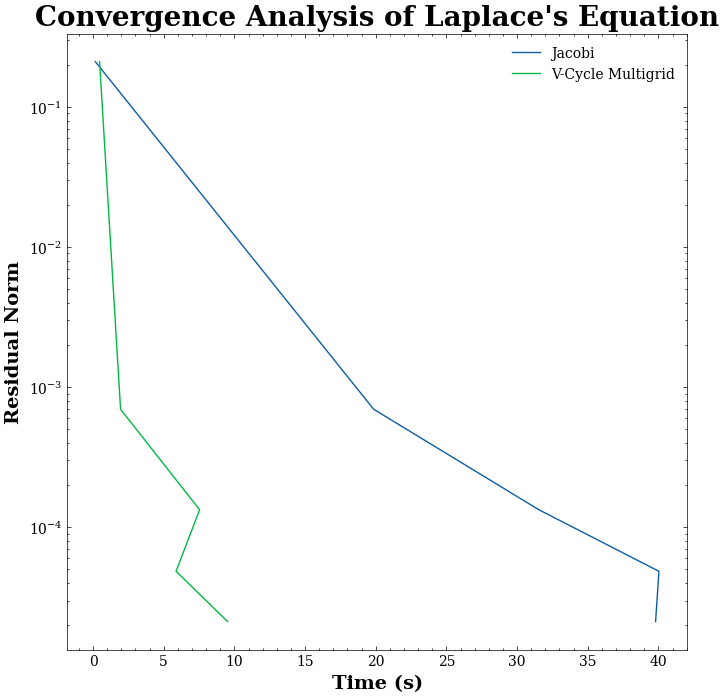

In [ ]:
it_arr = np.linspace(1,30, 5)
tol_arr = []
multigrid_t_arr = []
jacobi_t_arr = []
for it in it_arr:
    tol, t = multigrid_laplace(int(it))
    multigrid_t_arr.append(t)
    tol_arr.append(tol)
    _,jac_t = jacobi_laplace(tol)
    jacobi_t_arr.append(jac_t)

fig = plt.figure(figsize=(8,8))
plt.xlabel('Time (s)', fontweight="bold",fontsize=14)
plt.ylabel('Residual Norm', fontweight="bold",fontsize=14)
plt.title("Convergence Analysis of Laplace's Equation", fontweight="bold", fontsize=20)
plt.grid(color = 'white',which='major', alpha=0.5)
plt.grid(color = 'white',which='minor', alpha=0.2)
plt.plot(jacobi_t_arr, tol_arr, label='Jacobi')
plt.plot(multigrid_t_arr, tol_arr, label='V-Cycle Multigrid')
plt.yscale('log')
plt.legend()
plt.show()

## **Part II: Learning with Machine Learning**

I utilized the Neural Implicit Flow [2] ML architecture due to some of its appealing properties. In particular, it is mesh agnostic, meaning it attempts to learn the continuous field solution from sparse measurements. In this case, that enables relatively course grids. It also isolates spatial queries from any other parametric dependencies using two different models connected through an autoencoder for efficient inference. The following downloads will enable you to use my trained model (or train one of your own). 

In [ ]:
"""
OPTIONAL CELL: Run to link your drive if you want to train/restore the model instead of using my pre-trained model
"""

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Training Data**

To train the model, training data was generated using the RK-45 Explicit Runge Kutta integrator on a course mesh, with time derivatives obtained using finite differences.



In [68]:
# Generates our uniform box with a 'point source' of heat
def gen_state0(x,y,T):
    state0 = np.zeros([33, 33])
    state0[x,y] = T
    return state0

# finite difference for 2nd order central difference
def fin_diff_2nd(vector, dl):
    vxx = [0]
    for i in range(np.shape(vector)[0]-2):
        vxx.append((vector[i+2]+vector[i]-2*vector[i+1])/(dl**2))
    vxx.append(0)
    return np.array(vxx)

#calculates FD 2nd partial derivatives for the mesh in each dimension
def uxx(mesh, dl):
    nx, ny = mesh.shape
    uxx = np.zeros([nx, ny]) # matrix of 2nd partial derivatives of field wrt x
    for y in range(ny):
      vector = mesh[:,y]
      uxx[:,y] = fin_diff_2nd(vector, dl)
    return uxx

def uyy(mesh,dl):
    nx, ny = np.shape(mesh)
    uyy = np.zeros([nx, ny]) 
    for x in range(nx):
      vector = mesh[x]
      uyy[x] = fin_diff_2nd(vector, dl)
    return uyy

def ut(t, mesh, nx, ny, dl):
    mesh = mesh.reshape(nx,ny)
    ut = 0.05*(uxx(mesh, dl)+uyy(mesh,dl)) # 0.05 factor helps the heat not diffuse too quicly over 1s for a source of strength in range[10,20]
    return ut.flatten()

# will plot a slice of the mesh of the temperature at a plane normal to the x-axis 
def plotDomain(mesh):
    pos = plt.imshow(mesh,
              extent =[-1, 1, -1, 1],
              interpolation='nearest', cmap='rainbow', origin ='lower')
    plt.xlabel('Y')
    plt.ylabel('X')
    plt.title("Temperature on Domain")
    plt.colorbar(pos)

**Designate a particular solution trajectory to train to**

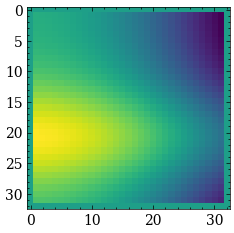

In [69]:

def initialT(x,y,dl):
    x *= dl
    y *= dl
    return 2*np.exp(-1*np.cos(5*x)) - 10*np.sin(y**2)

coords = np.linspace(-1, 1, 33)
t_eval = np.arange(0,1, 0.02)

state0 = np.zeros([33,33])
dl = 1/state0.shape[0]
for x in range(1,state0.shape[0]-1):
    for y in range(1,state0.shape[1]-1):
        state0[x,y] = initialT(x,y, dl)
        
plt.imshow(state0)

# Integrate then form dataset
sol = solve_ivp(ut, t_span=(t_eval[0], t_eval[-1]), y0=state0.flatten(), t_eval=t_eval,args=(33, 33, dl))
In = []
Out = []
for t in range(50):
  D_t = sol.y[:,t].reshape(33,33)
  temp_inp = np.array([t*0.02, 0, 0])
  
  # Don't train to BC
  for x in range(1,state0.shape[0]-1):
    for y in range(1,state0.shape[1]-1):
      inp = temp_inp.copy()
      inp[-2:] = [coords[x], coords[y]] 
      out = np.array([D_t[x,y].copy()])
      In.append(inp)
      Out.append(out)     
In = np.array(In)
Out = np.array(Out)

# Normalization Procedure
I_shift = (In[:,0].max(axis=0) + In[:,0].min(axis=0)) / 2 
I_scale = (In[:,0].max(axis=0) - In[:,0].min(axis=0)) / 2 
O_shift = Out.mean()#(Out.max(axis=0) + Out.min(axis=0)) / 2 
O_scale = Out.std()#(Out.max(axis=0) - Out.min(axis=0)) / 2 

In, Out = shuffle(In, Out)
In[:,0] = (In[:,0]-I_shift)/I_scale
Out = (Out-O_shift) / O_scale

**Helper Functions**

These functions enable training and checkpointing of the models while also storing predictions at various stages of the training process. 

In [70]:
# Load/Use the trained model
def load_model(SNET_params, PNET_params, mixed_policy, ckptdir):
    new_model_ori = nif.NIFMultiScaleLastLayerParameterized(SNET_params, PNET_params, mixed_policy)
    new_model = new_model_ori.model()
    x_index = [0,1,2]
    y_index = [0]
    y_and_dydx_and_d2ydx2_layer = HessianLayer(new_model, y_index, x_index)
    y, dydx, d2ydx2 = y_and_dydx_and_d2ydx2_layer(new_model.inputs[0])
    print(y.shape, dydx.shape, d2ydx2.shape)
    
    dydx_1d = tf.reshape(dydx, [-1,3])

    d2ydx2_1d = tf.reshape(tf.linalg.diag_part(d2ydx2), [-1,3])
    y_dydx_d2ydx2_1d = tf.concat([y, dydx_1d, d2ydx2_1d], -1)
    model_opt = tf.keras.Model([new_model.inputs[0]], [y_dydx_d2ydx2_1d])
    model_opt.load_weights(ckptdir)
    #optimizer = tf.keras.optimizers.Adam(learn)
    #new_model.compile(optimizer, loss='mse')
    return model_opt

def format_input(t=((0-I_shift)/I_scale)):
    """
    Returns the array that should be passed to trained model for predictions.
    Useful for examining model training (eg. printing a prediction)
    Designed specifically for systems that had sensors regularly distributed over the space
    """
    coords = np.linspace(-1, 1, 99)
    temp_inp = np.array([t, 0, 0])
    
    In = np.empty((97,97,3))
    # Don't train to BC

    for x in range(In.shape[0]):
      for y in range(In.shape[1]):
        inp = temp_inp.copy()
        inp[-2:] = [coords[x+1], coords[y+1]] 
        In[x,y] = inp

    return In
    
def gen_sample(f,batch_size,specific=None):
    """
    Inputs: 
    f: file path
    batch_size: number of consecutively stored entries desired
    specific: allows user to specify the index to draw from. Not all that useful when 
    data is shuffled

    Returns: Sample from specified dataset. 
    """
    if specific is not None:
        I = f['Input'][specific:specific+batch_size]
        O = f['Output'][specific:specific+batch_size]

    else:
        ndata = f['Input'].shape[0]
        beg = random.randint(0,ndata*0.8-batch_size-1)
        I = f['Input'][beg:beg+batch_size] #np.zeros((batch_size, 6915))
        O = f['Output'][beg:beg+batch_size] #np.zeros((batch_size,4))

    return I,O

def scheduler(epoch, lr):
    if epoch < nepoch/5:
        return learn
    elif epoch < nepoch/2.5:
        return learn/5
    elif epoch < nepoch/1.25:
        return learn/10
    else:
        return learn/50 


""" Creates training log, periodically checkpoints the model, plots predictions vs truth"""
# custom callback 
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_begin_time = time.time()
        self.history_loss = []
        logging.basicConfig(filename='{}/log'.format(direc), level=logging.INFO, format='%(message)s')

    def on_epoch_begin(self, epoch, logs=None):
        self.ts = time.time()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % display_epoch == 0:
            tnow = time.time()
            te = tnow - self.ts
            logging.info("Epoch {:6d}: avg.loss pe = {:4.3e}, {:d} points/sec, time elapsed = {:4.3f} hours".format(
                epoch, logs['loss'], int(batch_size / te), (tnow - self.train_begin_time) / 3600.0))
            self.history_loss.append(logs['loss'])

        if epoch % checkpt_epoch == 0 or epoch == nepoch - 1:
            print('save checkpoint epoch: %d...' % epoch)
            self.model.save_weights("{}/saved_weights/ckpt-{}/ckpt".format(direc,epoch))
    
        if epoch % print_figure_epoch == 0:
            plt.figure()
            plt.semilogy(self.history_loss)
            plt.xlabel('epoch: per {} epochs'.format(print_figure_epoch))
            plt.ylabel('MSE loss')
            plt.savefig('{}/loss.png'.format(direc, epoch))
            plt.close()


            fig, (ax1, ax2) = plt.subplots(figsize=(16,8), ncols=2)
            In1 = format_input().reshape(-1,3)
            In2 = format_input(t=((1-I_shift)/I_scale)).reshape(-1,3)
            pred1 = np.zeros((99,99,1))
            pred2 = np.zeros((99,99,1))
            pred1[1:-1,1:-1] = (self.model.predict_on_batch(In1).reshape(97,97,7)[:,:,0].reshape(97,97,1)*O_scale) + O_shift # #[:,:,0].reshape(97,97,1)
            pred2[1:-1,1:-1] = (self.model.predict_on_batch(In2).reshape(97,97,7)[:,:,0].reshape(97,97,1)*O_scale) + O_shift
            ax1.imshow(pred1,
                extent =[-1, 1, -1, 1],
                interpolation='nearest', cmap='rainbow', origin ='lower')
            
            ax2.imshow(pred2,
                extent =[-1, 1, -1, 1],
                interpolation='nearest', cmap='rainbow', origin ='lower')

            plt.savefig('{}/vis_multiscale_{}.png'.format(direc, epoch))
            plt.close()



N_S_Units = 30
N_S_Layers = 3
N_P_Units = 20
N_P_Layers = 2
Rank_Linear = 5

extra = "SingleTraj"
path = "drive/MyDrive/ColabNotebooks/"
direc = "{}Models/{}-{}-{}-{}-{}-{}".format(path, extra, N_S_Units, N_S_Layers, N_P_Units, N_P_Layers, Rank_Linear)

#os.system("rm -r %s" % direc)
#os.system("mkdir %s" % direc)
enable_multi_gpu = False
enable_mixed_precision = False

# mixed precision?
if enable_mixed_precision:
    mixed_policy = "mixed_float16"
    # we might need this for `model.fit` to automatically do loss scaling
    policy = nif.mixed_precision.Policy(mixed_policy)
    nif.mixed_precision.set_global_policy(policy)
else:
    mixed_policy = 'float32'


cfg_shape_net = {
    "use_resblock":True,
    "connectivity": 'last_layer',
    "input_dim": 2,
    "output_dim": 1,
    "units": N_S_Units,
    "nlayers": N_S_Layers,
    "activation": 'swish',
    "weight_init_factor": 0.01,
    "omega_0":30.0
}
cfg_parameter_net = {
    "use_resblock":True,
    "input_dim": 1,
    "latent_dim": Rank_Linear,
    "units": N_P_Units,
    "nlayers": N_P_Layers,
    "activation": 'swish',
}
nepoch = 100
learn = 1e-3
batch_size = 1600
checkpt_epoch = nepoch/10
display_epoch = checkpt_epoch
print_figure_epoch = 10 #display_epoch

**Train the Model**

**NOTE:** Don't run this cell unless you have linked your Google Drive already in the first cell and want to save models and regular predictions inside of GD. The cell after will allow you to load my trained model without training it yourself and reproduce all results as advertised.

In [ ]:
"""
scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
TerminateOnNaN = tf.keras.callbacks.TerminateOnNaN()
callbacks = [TerminateOnNaN, LossAndErrorPrintingCallback(), scheduler_callback]

cm = tf.distribute.MirroredStrategy().scope() if enable_multi_gpu else nullcontext()
with cm:
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.MeanSquaredError()
    model_ori = nif.NIFMultiScaleLastLayerParameterized(cfg_shape_net, cfg_parameter_net, mixed_policy) # LastLayerParameterized
    model_opt = model_ori.build()

    #x_index = [0,1,2]
    #y_index = [0]
    #y_and_dydx_and_d2ydx2_layer = HessianLayer(model_opt, y_index, x_index)
    #y, dydx, d2ydx2 = y_and_dydx_and_d2ydx2_layer(model_opt.inputs[0])
    #print(y.shape, dydx.shape, d2ydx2.shape)
    
    #dydx_1d = tf.reshape(dydx, [-1,3])

    #d2ydx2_1d = tf.reshape(tf.linalg.diag_part(d2ydx2), [-1,3])
    #y_dydx_d2ydx2_1d = tf.concat([y, dydx_1d, d2ydx2_1d], -1)
    #model_opt = tf.keras.Model([model_opt.inputs[0]], [y_dydx_d2ydx2_1d])
    
    # Couldn't get gradient constraint to work correctly so I have commented out parts so that it is just regular MSE
    class PINN_Loss(tf.keras.losses.Loss):
      def call(self, y_true, y_pred):
          coef_grad = 1e-5
          sd_field = tf.square(y_true - y_pred[:,:1]) # enforce the specific solution
          #sd_grad = tf.square(y_pred[:,1] - 0.05*tf.reduce_sum(y_pred[:,5] + y_pred[:,6])) # enforce heat equation (general solution)
          return tf.reduce_mean(sd_field,axis=-1) #+ coef_grad*tf.reduce_mean(sd_grad,axis=-1)
    model_opt.compile(optimizer, loss=PINN_Loss()) # PINN_Loss()

start = time.time()
#model_opt.fit(generator(hdf5_file, batch_size=batch_size), epochs=nepoch, steps_per_epoch=int(ndata/batch_size),verbose=1, callbacks=callbacks, use_multiprocessing=False)
model_opt.fit(In, Out, batch_size=batch_size,epochs=nepoch, steps_per_epoch=int(ndata/batch_size),verbose=1, callbacks=callbacks)
end = time.time()

print("Training Time: ", end-start)
"""

**Load in Model**

In [ ]:
# Use commented code if you want to load from drive
"""
extra = "SingleTraj"
path = "drive/MyDrive/ColabNotebooks/"
direc = "{}Models/{}-{}-{}-{}-{}-{}".format(path, extra, N_S_Units, N_S_Layers, N_P_Units, N_P_Layers, Rank_Linear)
model = load_model(cfg_shape_net, cfg_parameter_net, mixed_policy, direc+"/saved_weights/ckpt-99/ckpt")
"""
extra = "SingleTraj"
model_opt = load_model(cfg_shape_net, cfg_parameter_net, mixed_policy, "Laplacian-NIF/ckpt")

(None, 1) (None, 1, 3) (None, 1, 3, 3)


## **Results and Discussion**

###**Part I: V-cycle Multigrid**

After discovering multigrid's success in solving the static Laplace Equation, I applied it to the time-dependent Laplace heat equation. Below, I show how my solver was able to solve high resolution meshes at high accuracy. Below, I implement the same graph shown above to demonstrate the difference in scaling. It looks slightly different due to Colab's inconsistent computation allocation resulting in some strange deviations, but the underlying trend remains regardless.  

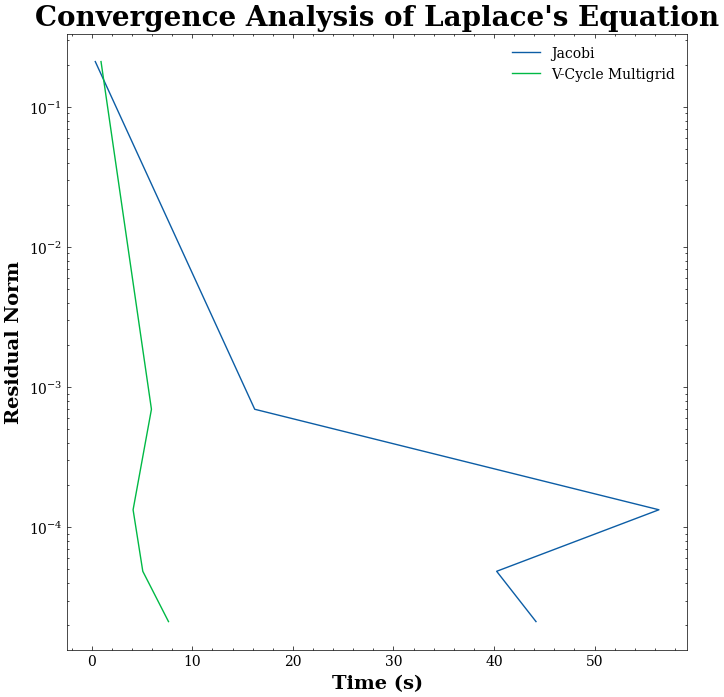

In [89]:
it_arr = np.linspace(1,30, 5)
tol_arr = []
multigrid_t_arr = []
jacobi_t_arr = []
for it in it_arr:
    tol, t = multigrid_laplace(int(it))
    multigrid_t_arr.append(t)
    tol_arr.append(tol)
    _,jac_t = jacobi_laplace(tol)
    jacobi_t_arr.append(jac_t)

fig = plt.figure(figsize=(8,8))
plt.xlabel('Time (s)', fontweight="bold",fontsize=14)
plt.ylabel('Residual Norm', fontweight="bold",fontsize=14)
plt.title("Convergence Analysis of Laplace's Equation", fontweight="bold", fontsize=20)
plt.grid(color = 'white',which='major', alpha=0.5)
plt.grid(color = 'white',which='minor', alpha=0.2)
plt.plot(jacobi_t_arr, tol_arr, label='Jacobi')
plt.plot(multigrid_t_arr, tol_arr, label='V-Cycle Multigrid')
plt.yscale('log')
plt.legend()
plt.show()

Note the vast difference in the scaling between Jacobi and Multigrid! Multigrid clearly outperforms Jacobi and this trend continues if higher-fidelity solutions are sought. 

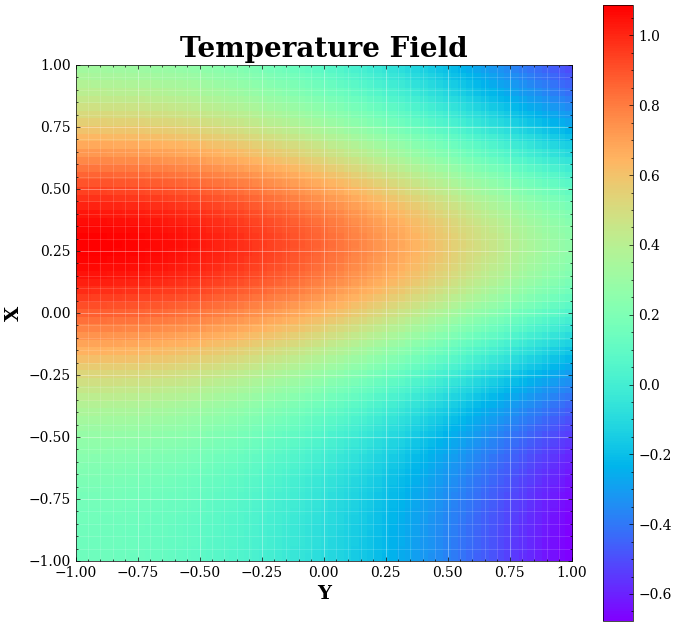

Initial Residual Norm 4.044072055324643
After one V-cycle (3 jacobi per level):  21.50475820874074


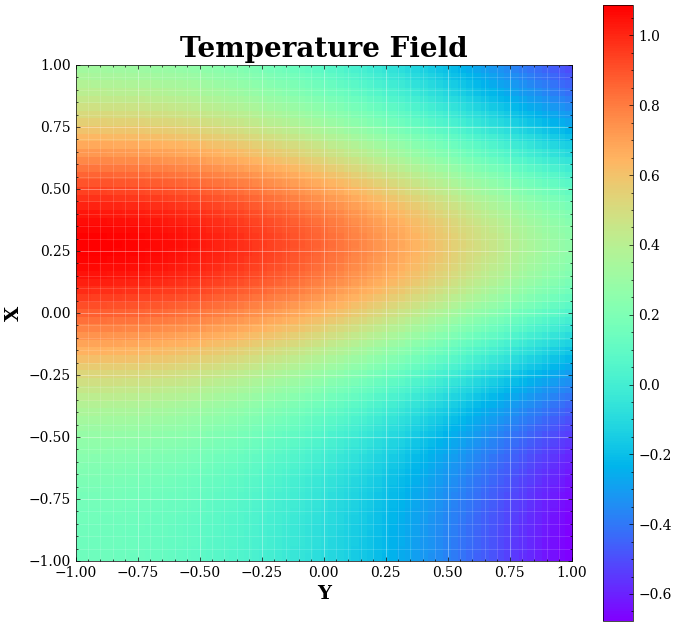

In [86]:
"""Time Dependent Heat Equation"""

# Dimension, potential, target convergence 
M = 65         # Side length/n_points, must be odd!!!
dl = 1.0/M
dt = 1
alpha = 0.005
bc_factor = alpha*dt*(M**2)

# function to assign initial temperature values to points on mesh
def initialT(x,y,dx):
    x *= dx
    y *= dx
    return 0.4*np.exp(-1*np.cos(5*x)) - np.sin(y**2)

def construct_L(n):
    A = construct_A(n)
    I = np.identity(A.shape[0])
    L = I - bc_factor*A
    return L
    
# assigning mesh values for initial snapshot
T0 = np.zeros([M, M])
for x in range(T0.shape[0]):
    for y in range(T0.shape[1]):
        T0[x,y] = initialT(x,y, dl)

fig = plt.figure(figsize=(8,8))
plotDomain(T0)
plt.show()
iter_max = 3


T1 = T0.copy()
#T1[1:-1,1:-1] = 0

# move Dirichlet boundary conditions to b to avoid interfering with it
b =  T0[1:-1, 1:-1].copy()
b[-1] += T1[-1,1:-1]*bc_factor
b[0] += T1[0,1:-1]*bc_factor
b[:,-1] += T1[1:-1,-1]*bc_factor
b[:,0] += T1[1:-1,0]*bc_factor

L = construct_L(M-2)

#Demonstration for single V-cycle
MGS = MultiGridSolver2D(construct_L, b, T1, dim=M, iter_max=iter_max)
x = MGS.solve(30)
fig = plt.figure(figsize=(8,8))
plotDomain(x)
plt.title("1 V-cycle")
plt.show()
print("Initial Residual Norm", np.linalg.norm(b.flatten() - L@T1[1:-1,1:-1].flatten()))
print("After one V-cycle (%i jacobi per level): "%iter_max, np.linalg.norm(b.flatten()-L@x[1:-1,1:-1].flatten()))
"""Time Dependent Heat Equation"""

# Dimension, potential, target convergence 
M = 65         # Side length/n_points, must be odd!!!
dl = 1.0/M
dt = 0.05
bc_factor = alpha*dt*(M**2)
iter_max = 3


# function to assign initial temperature values to points on mesh
def initialT(x,y,dx):
    x *= dx
    y *= dx
    return 0.4*np.exp(-1*np.cos(5*x)) - np.sin(y**2)

def construct_L(n):
    A = construct_A(n)
    I = np.identity(A.shape[0])
    L = I - A*bc_factor
    return L
    
# assigning mesh values for initial snapshot
T0 = np.zeros([M, M])
for x in range(T0.shape[0]):
    for y in range(T0.shape[1]):
        T0[x,y] = initialT(x,y, dl)

fig = plt.figure(figsize=(8,8))
plotDomain(T0)
plt.show()
iter_max = 3

#T1[1:-1,1:-1] = 0

L = construct_L(M-2)

field_traj = np.empty([100,65,65])
field_traj[0] = T0

for i in range(1,100):
    # move Dirichlet boundary conditions to b to avoid interfering with it
    T1 = field_traj[i-1].copy()
    b =  field_traj[i-1, 1:-1, 1:-1].copy()
    b[-1] += T1[-1,1:-1]*bc_factor
    b[0] += T1[0,1:-1]*bc_factor
    b[:,-1] += T1[1:-1,-1]*bc_factor
    b[:,0] += T1[1:-1,0]*bc_factor
    
    MGS = MultiGridSolver2D(construct_L, b, T1, dim=M, iter_max=iter_max)
    T0 = MGS.solve(10)
    field_traj[i] = T0.copy()
    #plotDomain(T0)
    #plt.show()

In [88]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, (ax1) = plt.subplots(figsize=(12,6), ncols=1)
major_ticks = np.arange(-1, 1.2, 0.4)
minor_ticks = np.arange(-1, 1.05, 0.1)

def animate(i):
    x = int(i*5)
    pred = field_traj[x]
    pos = ax1.imshow(pred,
              extent =[-1, 1, -1, 1],
              interpolation='nearest', cmap='rainbow', origin ='lower')


    ax1.set_xlabel("Y", fontweight="bold",fontsize=14)
    ax1.set_ylabel("X", fontweight="bold",fontsize=14)
    ax1.set_title("Multigrid Solution", fontweight="bold",fontsize=20)

    ax1.set_yticks(major_ticks)
    ax1.set_xticks(minor_ticks, minor=True)
    ax1.set_yticks(minor_ticks, minor=True)
    ax1.grid(color = 'white',which='major', alpha=0.5)
    ax1.grid(color = 'white',which='minor', alpha=0.2)
    plt.close()

ani = FuncAnimation(fig, animate, frames=20, interval=100, repeat=False)
HTML(ani.to_jshtml())

The general purpose V-cycle solver was able to accurately solve the heat equation at very very high resolution. Explicit Runge-Kutta 45 on a mesh with 1/4 the number of points struggled to accomplish this simulation within 5 minutes. In contrast, multigrid extended well to stepping the solution with high fidelity. The downside to this method is that boundary conditions must be dealt with very carefully which requires much thought and planning before posing the problem. However, the general Ax=b solution method is demonstrated to solve both time-dependent and time-independent equations. 

**Example for In-class presentation**

I used the plot below to explain the motivation of multigrid.

In [87]:
x = np.linspace(0, np.pi,20)
plt.figure(figsize=(12,8))
plt.scatter(x, np.sin(x), color='red')
plt.ylabel("Error", fontsize=14, fontweight='bold', )
plt.xlabel("X", fontsize=14, fontweight='bold', )
plt.title("1D PDE Error", fontweight='bold', fontsize=18)
plt.grid()

###**Part II: ML Model's Predictions**

This section demonstrates how the ML model learned the dynamics of a specific solution to the heat equation.

In [76]:
extra = "SingleTraj"
model_opt = load_model(cfg_shape_net, cfg_parameter_net, mixed_policy, "Laplacian-NIF/ckpt")

(None, 1) (None, 1, 3) (None, 1, 3, 3)


In [77]:
field_traj = np.zeros([50,99,99,1])
for i in range(50):
  t_true = 0.02*i
  t_norm = (t_true - I_shift) / I_scale
  I = format_input(t_true).reshape(-1,3)
  field_traj[i,1:-1,1:-1] = (model_opt.predict_on_batch(I).reshape(97,97,7)[:,:,0].reshape(97,97,1)*O_scale) + O_shift

fig, (ax1, ax2) = plt.subplots(figsize=(12,6), ncols=2)
major_ticks = np.arange(-1, 1.2, 0.4)
minor_ticks = np.arange(-1, 1.05, 0.1)

def animate(i):
    x = i#int(i*2)
    pred = field_traj[x]
    pos = ax1.imshow(pred,
              extent =[-1, 1, -1, 1],
              interpolation='nearest', cmap='rainbow', origin ='lower')


    ax1.set_xlabel("Y", fontweight="bold",fontsize=14)
    ax1.set_ylabel("X", fontweight="bold",fontsize=14)
    ax1.set_title("NIF Prediction", fontweight="bold",fontsize=20)

    mesh2 = sol.y[:,x].reshape(33,33)
    pos2 = ax2.imshow(mesh2, 
                extent =[-1, 1, -1, 1],
                interpolation='nearest', cmap='rainbow', origin ='lower')
    
    ax2.set_xlabel("Y", fontweight="bold",fontsize=14)
    ax2.set_ylabel("X", fontweight="bold",fontsize=14)
    ax2.set_title("Finite Difference", fontweight="bold",fontsize=20)

    ax1.set_xticks(major_ticks)
    ax1.set_yticks(major_ticks)
    ax1.set_xticks(minor_ticks, minor=True)
    ax1.set_yticks(minor_ticks, minor=True)
    ax1.grid(color = 'white',which='major', alpha=0.5)
    ax1.grid(color = 'white',which='minor', alpha=0.2)
    ax2.set_xticks(major_ticks)
    ax2.set_yticks(major_ticks)
    ax2.set_xticks(minor_ticks, minor=True)
    ax2.set_yticks(minor_ticks, minor=True)
    ax2.grid(color = 'white',which='major', alpha=0.5)
    ax2.grid(color = 'white',which='minor', alpha=0.2)
    plt.close()

ani = FuncAnimation(fig, animate, frames=25, interval=50, repeat=False)
HTML(ani.to_jshtml())

If you check out my github at: https://github.com/aaron-philip/Laplacian-NIF you will find a folder titled "HyperparameterExperiments". In it, you will find the scripts I used to test a wide variety of model hyperparamters. Despite this, you can see the final model still struggled to perform well. This was disappointing as I have implemented this model to learn dynamics of nuclei and in learning the chaotic Lorenz system. I followed a similar normalization procedure that has worked in the past and for my own previous successes but this did not seem too effective at encoding time-dynamics. I also attempted to implement a Physics-Informed Loss Function [2] such that the model is penalized for predictions violating the underlying physical law, but this was not effective.  


**NOTE**: I used the above github to do version control and make all results reproducible. 

##  **Conclusion and Perspectives**

**Learned**: During the course of this project, I learned a great deal (about multigrid algorithms in particular). I was able to implement a general v-cycle solver for static and time-dependent problems and explored how thin the computer's resources can be spread before significant bottlenecks are encountered. I also discovered the difficulties in using machine learning with problems if you do not pose them correctly. 

**Struggles**: I encountered many struggles during the course of this project. The two I would highlight were: 

1. Debugging my v-cycle code; it would run but exhibit the same scaling as Jacobi or give nonsense results. This was difficult, given the recursive nature of the code. 

2. It was difficult to try different ways to pose the problem to the ML solver, playing with hyperparameters and normalization procedures, and even implementing PINNs [2]. 

**Key Results**:  
1. My v-cycle solver exhibited robust scaling in solving Laplace's equation compared to Jacobi, requiring around 2.5 seconds to achieve a residual norm of $10^{-5}$ as compared to Jacobi requiring nearly 20 seconds to achieve the same level of convergence. 

2. My model could train with all inputs and outputs normalized between -1 and 1 and converged to MSE around $10^{-4}$, understanding the general shape of the solution, but missing key details especially in the time series. 

**Takeaways**:

1. It is really important to understand times when ML is the appropriate choice. When we have established methods like multigrid or explicit solvers such as Runge-Kutta that have guaranteed accuracies/convergence, we do not need ML to obtain high fidelity solutions. However, we can parallelize space but not time. When ML is able to learn a solution accurately, then it may be more advantageous to use it for long time-scale phenomena (or even a hybrid!). 

2. Multigrid is a significantly more efficient method for certain types of PDE the way I already coded it. However, one thing I did not talk about is the sparsity of the matrix set up. Because I wanted my code to work for both static and time-dependent problems, I did not take advantage of the sparsity of the matrix (The Jacobi method did and still lost!). This could be implemented and we would see even better scaling with respect to convergence criterion.

## **References**

[1] S. Pan, S.L. Brunton, and J.N. Kutz: Neural Implicit Flow: a mesh-agnostic dimensionality reduction paradigm of spatio-temporal data, Journal of Machine Learning Research, JMLR:v24:22-0365, 2023

[2] M. Raissi, P. Perdikaris, G.E. Karniadakis, Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations, Journal of Computational Physics, ISSN 0021-9991, 2019